In [1]:
%pip install geopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np
import seaborn as sns
import geopy.distance

import matplotlib.pyplot as plt

import urllib.request
import json

In [3]:
db_name = "../database/e-commerce.db"

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    # YOUR CODE
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
        return conn
    except Error as e:
        print(e)
        


conn = create_connection(db_name)
conn

2.6.0


In [4]:

    cur = conn.cursor()
#     the table wight_cm can become width_cm   --> order_delivered_carrier_date == order_delivered_customer_date
    cur.execute('''
                SELECT 
                order_item.item_id, 
                order_item.freight_value, 
                order_item.price, 
                weight_g,
                lenght_cm, 
                height_cm, 
                width_cm, 
                customer.zip_code, 
                seller.zip_code, 
                order_dataset.purchase_timestamp,
                order_dataset.order_estimated_delivery_date, 
                order_dataset.order_delivered_customer_date
                FROM product
                LEFT JOIN order_item ON product.id = order_item.product_id
                LEFT JOIN order_dataset ON order_item.order_id = order_dataset.order_id
                LEFT JOIN customer ON customer.id = order_dataset.customer_id          
                LEFT JOIN seller ON order_item.seller_id = seller.id                
                ''')
    
    res_cur = cur.fetchall()
    

In [5]:
df_bdd = pd.DataFrame(res_cur, columns=["nb_product", "prix_de_livraison", "product_price", "weight", "lenght", "height", "width", "zip_code_customer", "zip_code_seller", "date_purchase", "date_delevery_estimate", "date_delivery"])
df_bdd

,nb_product,prix_de_livraison,product_price,weight,lenght,height,width,zip_code_customer,zip_code_seller,date_purchase,date_delevery_estimate,date_delivery
0,1,7.39,10.91,225.0,16.0,10.0,14.0,13848,3694,2018-04-24 16:16:53,2018-05-09 00:00:00,2018-04-27 16:42:17
1,1,17.99,248.00,1000.0,30.0,18.0,20.0,20551,2955,2018-01-31 18:55:36,2018-02-22 00:00:00,2018-02-16 13:27:08
2,1,7.82,79.80,154.0,18.0,9.0,15.0,5821,2016,2018-07-09 21:18:01,2018-07-18 00:00:00,2018-07-11 23:24:16
3,1,9.54,112.30,371.0,26.0,4.0,26.0,2018,13330,2018-08-03 08:55:50,2018-08-08 00:00:00,2018-08-06 15:14:32
4,1,8.29,37.90,625.0,20.0,17.0,13.0,5835,4461,2018-04-11 01:06:37,2018-04-26 00:00:00,2018-04-13 22:41:44
...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2,16.11,29.90,700.0,31.0,13.0,20.0,38130,13720,2018-01-03 15:05:53,2018-02-02 00:00:00,2018-01-15 20:39:35
112646,1,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40
112647,2,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40
112648,3,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40


In [6]:
cur = conn.cursor()
#     the table wight_cm can become width_cm   --> order_delivered_carrier_date == order_delivered_customer_date
cur.execute('''
            SELECT 
            zip_code, latitude, longitude
            FROM geolocation
            ''')

res_cur = cur.fetchall()

df_geoloc = pd.DataFrame(res_cur, columns=["zip_code", "latitude", "longitude"])
df_geoloc


,zip_code,latitude,longitude
0,1037,-23.545621,-46.639292
1,1046,-23.546081,-46.644820
2,1046,-23.546129,-46.642951
3,1041,-23.544392,-46.639499
4,1035,-23.541578,-46.641607
...,...,...,...
1000158,99950,-28.068639,-52.010705
1000159,99900,-27.877125,-52.224882
1000160,99950,-28.071855,-52.014716
1000161,99980,-28.388932,-51.846871


In [7]:
df_bdd = df_bdd.merge(df_geoloc.drop_duplicates(['zip_code']), left_on='zip_code_customer', right_on='zip_code', how="left", suffixes = ("","_customer"))
df_bdd

,nb_product,prix_de_livraison,product_price,weight,lenght,height,width,zip_code_customer,zip_code_seller,date_purchase,date_delevery_estimate,date_delivery,zip_code,latitude,longitude
0,1,7.39,10.91,225.0,16.0,10.0,14.0,13848,3694,2018-04-24 16:16:53,2018-05-09 00:00:00,2018-04-27 16:42:17,13848.0,-22.331249,-46.922580
1,1,17.99,248.00,1000.0,30.0,18.0,20.0,20551,2955,2018-01-31 18:55:36,2018-02-22 00:00:00,2018-02-16 13:27:08,20551.0,-22.915371,-43.242996
2,1,7.82,79.80,154.0,18.0,9.0,15.0,5821,2016,2018-07-09 21:18:01,2018-07-18 00:00:00,2018-07-11 23:24:16,5821.0,-23.666423,-46.753278
3,1,9.54,112.30,371.0,26.0,4.0,26.0,2018,13330,2018-08-03 08:55:50,2018-08-08 00:00:00,2018-08-06 15:14:32,2018.0,-23.493511,-46.631067
4,1,8.29,37.90,625.0,20.0,17.0,13.0,5835,4461,2018-04-11 01:06:37,2018-04-26 00:00:00,2018-04-13 22:41:44,5835.0,-23.653137,-46.759223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2,16.11,29.90,700.0,31.0,13.0,20.0,38130,13720,2018-01-03 15:05:53,2018-02-02 00:00:00,2018-01-15 20:39:35,38130.0,-19.760147,-48.571943
112646,1,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405
112647,2,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405
112648,3,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405


In [8]:
df_bdd = df_bdd.merge(df_geoloc.drop_duplicates(['zip_code']), left_on='zip_code_seller', right_on='zip_code', how="left", suffixes = ("","_seller"))
df_bdd

,nb_product,prix_de_livraison,product_price,weight,lenght,height,width,zip_code_customer,zip_code_seller,date_purchase,date_delevery_estimate,date_delivery,zip_code,latitude,longitude,zip_code_seller,latitude_seller,longitude_seller
0,1,7.39,10.91,225.0,16.0,10.0,14.0,13848,3694,2018-04-24 16:16:53,2018-05-09 00:00:00,2018-04-27 16:42:17,13848.0,-22.331249,-46.922580,3694.0,-23.537922,-46.477696
1,1,17.99,248.00,1000.0,30.0,18.0,20.0,20551,2955,2018-01-31 18:55:36,2018-02-22 00:00:00,2018-02-16 13:27:08,20551.0,-22.915371,-43.242996,2955.0,-23.468441,-46.720688
2,1,7.82,79.80,154.0,18.0,9.0,15.0,5821,2016,2018-07-09 21:18:01,2018-07-18 00:00:00,2018-07-11 23:24:16,5821.0,-23.666423,-46.753278,2016.0,-23.500978,-46.627123
3,1,9.54,112.30,371.0,26.0,4.0,26.0,2018,13330,2018-08-03 08:55:50,2018-08-08 00:00:00,2018-08-06 15:14:32,2018.0,-23.493511,-46.631067,13330.0,-23.089035,-47.214419
4,1,8.29,37.90,625.0,20.0,17.0,13.0,5835,4461,2018-04-11 01:06:37,2018-04-26 00:00:00,2018-04-13 22:41:44,5835.0,-23.653137,-46.759223,4461.0,-23.692896,-46.680210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2,16.11,29.90,700.0,31.0,13.0,20.0,38130,13720,2018-01-03 15:05:53,2018-02-02 00:00:00,2018-01-15 20:39:35,38130.0,-19.760147,-48.571943,13720.0,-21.592175,-46.893896
112646,1,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896
112647,2,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896
112648,3,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896


In [9]:
df_bdd = df_bdd.rename({'latitude': 'latitude_customer', 'longitude': 'longitude_customer'}, axis=1)
df_bdd

,nb_product,prix_de_livraison,product_price,weight,lenght,height,width,zip_code_customer,zip_code_seller,date_purchase,date_delevery_estimate,date_delivery,zip_code,latitude_customer,longitude_customer,zip_code_seller,latitude_seller,longitude_seller
0,1,7.39,10.91,225.0,16.0,10.0,14.0,13848,3694,2018-04-24 16:16:53,2018-05-09 00:00:00,2018-04-27 16:42:17,13848.0,-22.331249,-46.922580,3694.0,-23.537922,-46.477696
1,1,17.99,248.00,1000.0,30.0,18.0,20.0,20551,2955,2018-01-31 18:55:36,2018-02-22 00:00:00,2018-02-16 13:27:08,20551.0,-22.915371,-43.242996,2955.0,-23.468441,-46.720688
2,1,7.82,79.80,154.0,18.0,9.0,15.0,5821,2016,2018-07-09 21:18:01,2018-07-18 00:00:00,2018-07-11 23:24:16,5821.0,-23.666423,-46.753278,2016.0,-23.500978,-46.627123
3,1,9.54,112.30,371.0,26.0,4.0,26.0,2018,13330,2018-08-03 08:55:50,2018-08-08 00:00:00,2018-08-06 15:14:32,2018.0,-23.493511,-46.631067,13330.0,-23.089035,-47.214419
4,1,8.29,37.90,625.0,20.0,17.0,13.0,5835,4461,2018-04-11 01:06:37,2018-04-26 00:00:00,2018-04-13 22:41:44,5835.0,-23.653137,-46.759223,4461.0,-23.692896,-46.680210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2,16.11,29.90,700.0,31.0,13.0,20.0,38130,13720,2018-01-03 15:05:53,2018-02-02 00:00:00,2018-01-15 20:39:35,38130.0,-19.760147,-48.571943,13720.0,-21.592175,-46.893896
112646,1,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896
112647,2,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896
112648,3,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896


## pour trouver la distance entre les geolocalisation nous tester plusieurs solutions.
### Solution 1:

In [10]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(-22.2569861454338)
lon1 = radians(-45.6968690671541)
lat2 = radians(-22.4733036420427)
lon2 = radians(-45.6139087768263)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result:", distance)
print("Should be:", 278.546, "km")

Result: 25.52941069384593
Should be: 278.546 km



### Solution 2:
### nous decidons de garder d'utiliser cette methode car plus simple et lisible.

In [11]:
coords_1 = (-22.2569861454338, -45.6968690671541)
coords_2 = (-22.4733036420427, -45.6139087768263)

print(geopy.distance.geodesic(coords_1, coords_2).km)

25.432299832611168


In [12]:
distance = {"distance" : []
           }


for latitude_customer, longitude_customer, latitude_seller, longitude_seller in df_bdd[["latitude_customer","longitude_customer", "latitude_seller", "longitude_seller"]].to_numpy():
    coords_1 = (float(latitude_customer), float(longitude_customer))
    coords_2 = (float(latitude_seller), float(longitude_seller))
    try:
        res = geopy.distance.geodesic(coords_1, coords_2).km
        distance["distance"].append(res)
    except:
        distance["distance"].append(np.nan)
    
df_bdd["distance"] = distance["distance"]
df_bdd

# #     distance.append(geopy.distance.geodesic(coords_1, coords_2).km)
# for longitude, latitude in geoloc.items():
#     if longitude != 'nan' or latitude != 'nan':
#         print(longitude, latitude)




,nb_product,prix_de_livraison,product_price,weight,lenght,height,width,zip_code_customer,zip_code_seller,date_purchase,date_delevery_estimate,date_delivery,zip_code,latitude_customer,longitude_customer,zip_code_seller,latitude_seller,longitude_seller,distance
0,1,7.39,10.91,225.0,16.0,10.0,14.0,13848,3694,2018-04-24 16:16:53,2018-05-09 00:00:00,2018-04-27 16:42:17,13848.0,-22.331249,-46.922580,3694.0,-23.537922,-46.477696,141.206907
1,1,17.99,248.00,1000.0,30.0,18.0,20.0,20551,2955,2018-01-31 18:55:36,2018-02-22 00:00:00,2018-02-16 13:27:08,20551.0,-22.915371,-43.242996,2955.0,-23.468441,-46.720688,361.255505
2,1,7.82,79.80,154.0,18.0,9.0,15.0,5821,2016,2018-07-09 21:18:01,2018-07-18 00:00:00,2018-07-11 23:24:16,5821.0,-23.666423,-46.753278,2016.0,-23.500978,-46.627123,22.395881
3,1,9.54,112.30,371.0,26.0,4.0,26.0,2018,13330,2018-08-03 08:55:50,2018-08-08 00:00:00,2018-08-06 15:14:32,2018.0,-23.493511,-46.631067,13330.0,-23.089035,-47.214419,74.618935
4,1,8.29,37.90,625.0,20.0,17.0,13.0,5835,4461,2018-04-11 01:06:37,2018-04-26 00:00:00,2018-04-13 22:41:44,5835.0,-23.653137,-46.759223,4461.0,-23.692896,-46.680210,9.184295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2,16.11,29.90,700.0,31.0,13.0,20.0,38130,13720,2018-01-03 15:05:53,2018-02-02 00:00:00,2018-01-15 20:39:35,38130.0,-19.760147,-48.571943,13720.0,-21.592175,-46.893896,267.777831
112646,1,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004
112647,2,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004
112648,3,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004


### on verifie que les valeurs inserer avec geopy sont bonne

In [13]:
print(geopy.distance.geodesic((-22.331249, -46.922580), (-23.537922, -46.477696)).km)
print(geopy.distance.geodesic((-22.915371, -43.242996), (-23.468441, -46.720688)).km)

141.20689555303554
361.2555347525922


In [14]:
days = []
for date_purchase, date_delivery in df_bdd[["date_purchase", "date_delivery"]].to_numpy():
    try:
        res = pd.to_datetime(date_delivery) - pd.to_datetime(date_purchase)
        res = str(res).split(" ")[0]
        days.append(int(res))
    except:         
        days.append(np.nan)

        
df_bdd["days_to_delivery"] = days
df_bdd

,nb_product,prix_de_livraison,product_price,weight,lenght,height,width,zip_code_customer,zip_code_seller,date_purchase,date_delevery_estimate,date_delivery,zip_code,latitude_customer,longitude_customer,zip_code_seller,latitude_seller,longitude_seller,distance,days_to_delivery
0,1,7.39,10.91,225.0,16.0,10.0,14.0,13848,3694,2018-04-24 16:16:53,2018-05-09 00:00:00,2018-04-27 16:42:17,13848.0,-22.331249,-46.922580,3694.0,-23.537922,-46.477696,141.206907,3.0
1,1,17.99,248.00,1000.0,30.0,18.0,20.0,20551,2955,2018-01-31 18:55:36,2018-02-22 00:00:00,2018-02-16 13:27:08,20551.0,-22.915371,-43.242996,2955.0,-23.468441,-46.720688,361.255505,15.0
2,1,7.82,79.80,154.0,18.0,9.0,15.0,5821,2016,2018-07-09 21:18:01,2018-07-18 00:00:00,2018-07-11 23:24:16,5821.0,-23.666423,-46.753278,2016.0,-23.500978,-46.627123,22.395881,2.0
3,1,9.54,112.30,371.0,26.0,4.0,26.0,2018,13330,2018-08-03 08:55:50,2018-08-08 00:00:00,2018-08-06 15:14:32,2018.0,-23.493511,-46.631067,13330.0,-23.089035,-47.214419,74.618935,3.0
4,1,8.29,37.90,625.0,20.0,17.0,13.0,5835,4461,2018-04-11 01:06:37,2018-04-26 00:00:00,2018-04-13 22:41:44,5835.0,-23.653137,-46.759223,4461.0,-23.692896,-46.680210,9.184295,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2,16.11,29.90,700.0,31.0,13.0,20.0,38130,13720,2018-01-03 15:05:53,2018-02-02 00:00:00,2018-01-15 20:39:35,38130.0,-19.760147,-48.571943,13720.0,-21.592175,-46.893896,267.777831,12.0
112646,1,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004,17.0
112647,2,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004,17.0
112648,3,23.28,29.90,700.0,31.0,13.0,20.0,46190,13720,2018-03-06 11:51:44,2018-04-05 00:00:00,2018-03-23 20:08:40,46190.0,-13.446785,-42.246405,13720.0,-21.592175,-46.893896,1027.480004,17.0


<AxesSubplot:>

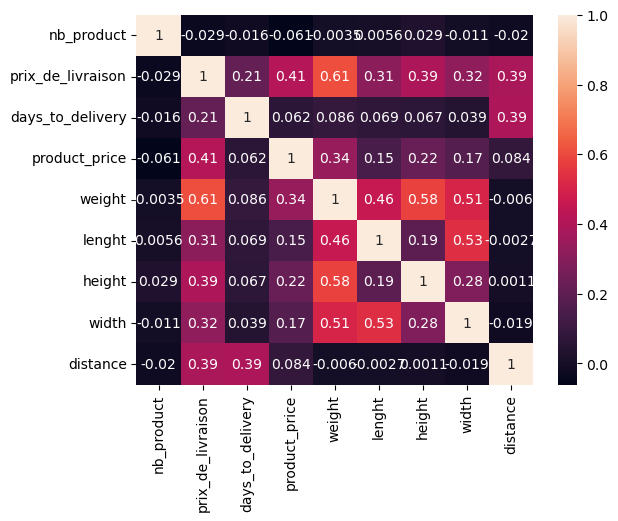

In [15]:
# calculate the correlation matrix
corr = df_bdd[["nb_product", "prix_de_livraison", "days_to_delivery", "product_price", "weight", "lenght", "height", "width", "distance"]].corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

In [ ]:
print('hello')